In [18]:
'''
This notebook helps us test the robustness of the autoencoder's training. 
What we ultimately care about is how well the particle identification (PID) classification problems 
are solved when run on the autoencoder's decoded features in comparison to the 
original features. 

There are many different PID classification problems. Let's pick one: Distinguishing particle "c" from everything else
'''

'\nThis notebook helps us test the robustness of the autoencoder\'s training. \nWhat we ultimately care about is how well the particle identification (PID) classification problems \nare solved when run on the autoencoder\'s decoded features in comparison to the \noriginal features. \n\nThere are many different PID classification problems. Let\'s pick one: Distinguishing particle "c" from everything else\n'

In [19]:
#Importing necessary libraries
import numpy as np
# from keras.layers import Input, Dense, Dropout
# from keras.models import Model, Sequential
# from keras.callbacks import EarlyStopping, TensorBoard
# from keras import optimizers
# from keras import backend as K
# import keras

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm

import math
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook

import string
plt.rc('text', usetex=False)

import pickle

from Autoencoder_Utils import *
from __future__ import print_function

In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from collections import OrderedDict

In [21]:
#Load Output from Neural Network training
TYPE = "" # 100% of the data. To determine the real performance of the cross check
#TYPE = "_10perc" #10% of the data. Used for everything except to determine the real performance of the cross check
#TYPE = "_1perc" #1% of the data. For small tests.
#TYPE = "_100" #100 samples of the data. For very rudimentary tests

ONLY_ONE_PID = True

pids = ['a', 'b', 'c', 'd', 'e']
pid_to_train = 2 #Pick a PID classification problem. Here we pick to distinguish particle 2 (=c) from everything else

retain_dict = pickle.load( open( "retain_dict_{}.p".format(TYPE), "rb" ) )
all_input = retain_dict.pop("test_input")
all_aux = retain_dict.pop("test_aux")
all_MC = retain_dict.pop("test_MC")
l_score = retain_dict.pop("l_score")
all_decoded_dict = retain_dict.pop("save_decoded_dict")

y = label_binarize(all_MC[:,0], classes=pids) # Checking electron ID

In [22]:
# Difining the Train, Validation and Test fractions. 

training_frac = 0.70
val_frac      = 0.20
n_samples = all_input.shape[0]
n_features_input = all_input.shape[1]
n_features_aux = all_aux.shape[1]
n_features_MC = all_MC.shape[1]

n_train = int(n_samples * training_frac)
n_val = int(n_samples * val_frac) 
n_test = int(n_samples * (1 - training_frac - val_frac))

print("Nb train exmaples " + str(n_train))
print("Nb val exmaples " + str(n_val))
print("Nb test exmaples " + str(n_test))

Nb train exmaples 522408
Nb val exmaples 149259
Nb test exmaples 74629


In [23]:
# Splitting the dataset. Here we use the autoencoder's test dataset (10% of the full data). 
# We divide this dataset into BDT cross check train, val and test datasets

train_val_input, test_input, train_val_y, test_y = train_test_split(
    all_input, y, random_state=42, train_size=training_frac + val_frac
)
train_input, val_input, train_y, val_y = train_test_split(
    train_val_input, train_val_y, random_state=42, train_size=training_frac / (training_frac + val_frac)
)
train_decoded_dict, val_decoded_dict, test_decoded_dict = {}, {}, {}

for encoding_dim in all_decoded_dict:
    all_dec = all_decoded_dict[encoding_dim]
    train_val_dec, test_dec = train_test_split(
        all_dec, random_state=42, train_size=training_frac + val_frac
    )
    train_dec, val_dec = train_test_split(
        train_val_dec, random_state=42, train_size=training_frac / (training_frac + val_frac)
    )
    
    train_decoded_dict[encoding_dim] = train_dec
    val_decoded_dict[encoding_dim] = val_dec
    test_decoded_dict[encoding_dim] = test_dec

/home/mivakhnenko/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [24]:
def TrainBDT(Atrain_input, Atrain_y, Aval_input, Ay_val):
    # Once again this is not optimised.
    # Using decision tree stumps
    bdt = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200
    )
    clf = OneVsRestClassifier(bdt)
#     bdt.fit(train_MC_input[:, n_features_MC:], train_MC_input[:, :n_features_MC])

    if ONLY_ONE_PID:
#         print(Atrain_y, pid_to_train)
#         print(Atrain_y[:, pid_to_train])
        clf.fit(Atrain_input, Atrain_y[:, pid_to_train])
        n_classes = 1
    else:
        clf.fit(Atrain_input, Atrain_y)
        n_classes = len(pids)

    y_score = clf.decision_function(Aval_input)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        if ONLY_ONE_PID: 
            fpr[i], tpr[i], _ = roc_curve(Ay_val[:, pid_to_train], y_score)
        else: 
            fpr[i], tpr[i], _ = roc_curve(Aval_y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    if n_classes != 1:
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(Aval_y.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    return fpr, tpr, roc_auc

In [25]:
# Making different Receiver Operating Characteristic Plots, to show the differences between 
# Training on 3 vs 9 autoencoder compressed features.
def PlotROC(d_fpr, d_tpr, d_roc_auc, i_class=0, title='Receiver operating characteristic'):
    plt.figure()
    lw = 2
    l_colors= ['darkorange', 'blue', 'red', 'green', 'black', 'yellow']
    for ikey, key in enumerate(d_fpr):
        plt.plot(
            d_fpr[key][i_class], d_tpr[key][i_class], color=l_colors[ikey],
            lw=lw, label=str(key) + ' AUC %0.3f' % d_roc_auc[key][i_class] 
        )
#     plt.plot(
#         fpr[i_class], tpr[i_class], color='darkorange',
#         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i_class]
#     )
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig("./img/ROC_{}.png".format(TYPE))
    plt.show()

    
def PlotROC1(d_fpr, d_tpr, d_roc_auc, i_class=0, title='Receiver operating characteristic'):
    plt.figure()
    lw = 2
    l_colors= ['darkorange', 'blue', 'red', 'green', 'black', 'yellow']
    for ikey, key in enumerate(d_fpr):
        plt.plot(
            d_tpr[key][i_class], 1 - d_fpr[key][i_class], color=l_colors[ikey],
            lw=lw, label=str(key) + ' AUC %0.3f' % d_roc_auc[key][i_class]
        )
#     plt.plot(
#         fpr[i_class], tpr[i_class], color='darkorange',
#         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i_class]
#     )
    plt.plot([1, 0], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylabel('1 - False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.savefig("./img/ROC1_{}.png".format(TYPE))
    plt.show()

    
def PlotROC2(d_fpr, d_tpr, d_roc_auc, i_class=0, title='Receiver operating characteristic'):
    plt.figure()
    lw = 2
    l_colors= ['darkorange', 'blue', 'red', 'green', 'black', 'yellow']
    for ikey, key in enumerate(d_fpr):
        plt.plot(
            d_tpr[key][i_class], 1 - d_fpr[key][i_class], color=l_colors[ikey],
            lw=lw, label=str(key) +' AUC %0.3f' % d_roc_auc[key][i_class]
        )
#     plt.plot(
#         fpr[i_class], tpr[i_class], color='darkorange',
#         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i_class]
#     )
    plt.plot([1, 0], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.9, 1.0])
    plt.ylim([0.4, 1.05])
    plt.ylabel('1 - False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.savefig("./img/ROC2_{}.png".format(TYPE))
    plt.show()
    
    
def PlotROC3(d_fpr, d_tpr, d_roc_auc, i_class=0, title='Receiver operating characteristic'):
    plt.figure()
    lw = 2
    l_colors= ['darkorange', 'blue', 'red', 'green', 'black', 'yellow']
    for ikey, key in enumerate(d_fpr):
        plt.plot(
            d_tpr[key][i_class], 1 - d_fpr[key][i_class], color=l_colors[ikey],
            lw=lw, label=str(key) +' AUC %0.3f' % d_roc_auc[key][i_class]
        )
#     plt.plot(
#         fpr[i_class], tpr[i_class], color='darkorange',
#         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i_class]
#     )
    plt.plot([1, 0], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.9, 0.94])
    plt.ylim([0.8, 1.05])
    plt.ylabel('1 - False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.savefig("./img/ROC3_{}.png".format(TYPE))
    plt.show()

In [26]:
%%time
d_fpr, d_tpr, d_roc_auc = OrderedDict(), OrderedDict(), OrderedDict()
res = TrainBDT(train_input, train_y, val_input, val_y)
d_fpr["orig"]= res[0]
d_tpr["orig"]= res[1]
d_roc_auc["orig"]= res[2]

l_encoding_dim = [1, 3, 6, 9, 18]

#for encoding_dim in all_decoded_dict:
for encoding_dim in tqdm(l_encoding_dim):
    res = TrainBDT(train_decoded_dict[encoding_dim], train_y, val_decoded_dict[encoding_dim], val_y)
    d_fpr[encoding_dim]= res[0]
    d_tpr[encoding_dim]= res[1]
    d_roc_auc[encoding_dim]= res[2]

100%|██████████| 5/5 [43:14<00:00, 517.14s/it]

CPU times: user 49min 56s, sys: 23.4 s, total: 50min 19s
Wall time: 50min 37s


In [27]:
title = "ROC electron 10% ECAL RICH Test Sample"

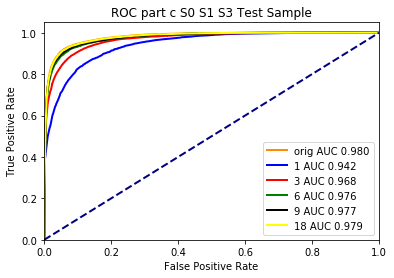

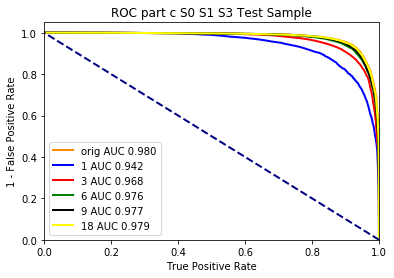

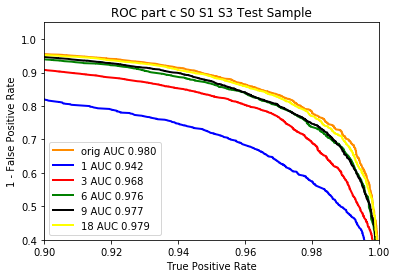

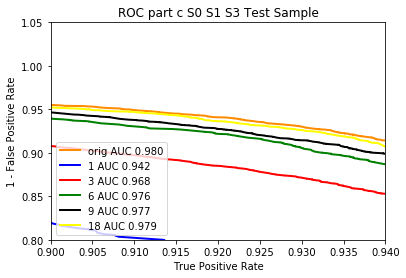

In [28]:
PlotROC(d_fpr, d_tpr, d_roc_auc, i_class = 0, title="ROC part c S0 S1 S3 Test Sample")
PlotROC1(d_fpr, d_tpr, d_roc_auc, i_class = 0, title="ROC part c S0 S1 S3 Test Sample")
PlotROC2(d_fpr, d_tpr, d_roc_auc, i_class = 0, title="ROC part c S0 S1 S3 Test Sample")
PlotROC3(d_fpr, d_tpr, d_roc_auc, i_class = 0, title="ROC part c S0 S1 S3 Test Sample")   

In [17]:
# The tighter the autoencoder compression the more AUC (area under the ROC curve) is lost. 
# However, the amount that is lost is tiny.
# One has to decide in practicality which compression factor is acceptable. 